# Gridded t-SNE image visualization

In [1]:
import hashlib
import functools
import itertools
from StringIO import StringIO
import json
import random

from PIL import Image, ImageChops
import requests
import concurrent.futures
import pandas as pd
import sklearn.decomposition
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import scipy.spatial.distance
import tqdm
import lapjv # pip install git+git://github.com/gatagat/lapjv.git

import clarifai.rest

sns.set_context('paper')
%matplotlib inline

 ## Set some parameters and get a list of urls to visualize

+ The API_KEY can be obtained from https://clarifai.com/developer/
+ We use a sample of photos posted to https://www.reddit.com/r/spaceporn/ but any list of working urls should be fine
 

In [2]:
API_KEY = 'XXXXXXXXXXXX'  # clarifai api key
IMAGES_PER_SIDE = 32  # number of images on each side of the final grid
IMG_SIZE = 64  # size of small images that make up the grid
NUM_IMAGES = IMAGES_PER_SIDE*IMAGES_PER_SIDE 
print 'NUM_IMAGES', NUM_IMAGES

resp = requests.get('https://s3.amazonaws.com/imtagco/blog/urls.txt')
urls = resp.content.split('\n')
urls = random.sample(urls, NUM_IMAGES + 600) #some buffer for bad urls

NUM_IMAGES 1024


## Download and compute embeddings

In [3]:
#Download and crop urls
def trim(im):
  bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
  diff = ImageChops.difference(im, bg)
  diff = ImageChops.add(diff, diff, 2.0, -100)
  bbox = diff.getbbox()
  if bbox:
    return im.crop(bbox)

def crop_image(img, xy, scale_factor):
  '''Crop the image around the tuple xy

  Inputs:
  -------
  img: Image opened with PIL.Image
  xy: tuple with relative (x,y) position of the center of the cropped image
      x and y shall be between 0 and 1
  scale_factor: the ratio between the original image's size and the cropped image's size
  '''
  center = (img.size[0] * xy[0], img.size[1] * xy[1])
  new_size = (img.size[0] / scale_factor, img.size[1] / scale_factor)
  left = max (0, (int) (center[0] - new_size[0] / 2))
  right = min (img.size[0], (int) (center[0] + new_size[0] / 2))
  upper = max (0, (int) (center[1] - new_size[1] / 2))
  lower = min (img.size[1], (int) (center[1] + new_size[1] / 2))
  cropped_img = img.crop((left, upper, right, lower))
  return cropped_img  

def download_one(url, resize=(IMG_SIZE,IMG_SIZE)):
  response = requests.get(url)
  try:
    stringio = StringIO(response.content)
    if resize:
      img = Image.open(stringio)
      if min(img.size) < 100:
        return
      img.thumbnail(resize, Image.ANTIALIAS)
      img.convert('RGB').save(stringio, format='JPEG')
    return stringio
  except:
    pass # meh
    
def download_many(urls):
  imgs = []
  with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    frs = tqdm.tqdm(executor.map(download_one, urls))
    for fr in frs:
      if fr:
        imgs.append(fr)
    executor.shutdown()
  return imgs

stringios = download_many(urls)
assert(len(stringios) >= NUM_IMAGES)

1624it [00:28, 56.93it/s]


In [4]:
#use the api to embed the cropped images

def embed_one(model, stringio):
  try:
    response = model.predict_by_bytes(stringio.getvalue())
  except:
    return
  output = response['outputs'][0]
  embedding = output['data']['embeddings'][0]['vector']
  embed_dic = {'embedding':embedding, 'stringio':stringio}
  return embed_dic

def embed_many(clarifai_client, stringios):
  embeddings = []
  embed_func = functools.partial(embed_one, clarifai_client)
  with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    frs = tqdm.tqdm(executor.map(embed_func, stringios))
    for fr in frs:
      if fr:
        embeddings.append(fr)
  return embeddings


#get clarifai general embedding model
clapp = clarifai.rest.ClarifaiApp(api_key=API_KEY) 
model = clapp.models.get(model_id='bbb5f41425b8468d9b7a554ff10f8581')

embedding_dics = embed_many(model, stringios)

1550it [01:39, 15.59it/s]


In [5]:
#use the embeddings to remove duplicates
df_embed = pd.DataFrame(embedding_dics)
df_embed['ehash'] = df_embed['embedding'].map(lambda x:hash(np.array(x).tostring()))
df_embed = df_embed.groupby('ehash').head(1)
uniq_embedding_dics = df_embed.sample(NUM_IMAGES).to_dict(orient='records')
print len(embedding_dics), len(uniq_embedding_dics)

1549 1024


## t-SNE the neural net embeddings down to 2D

In [6]:
#Dimension reduction
X = np.vstack([x['embedding'] for x in uniq_embedding_dics])
print X.shape

#denoise with pca (scikits reccomends this)
k = 512
pca = sklearn.decomposition.PCA(n_components=k)
X_kd = pca.fit_transform(X)

#barnes-hut t-sne
tsne = sklearn.manifold.TSNE()
X_2d = tsne.fit_transform(X)
print X_2d.shape

(1024, 1024)
(1024, 2)


## Snap the t-SNE'd points to a grid using lapjv

grid shape (1024, 2)
cost shape (1024, 1024)


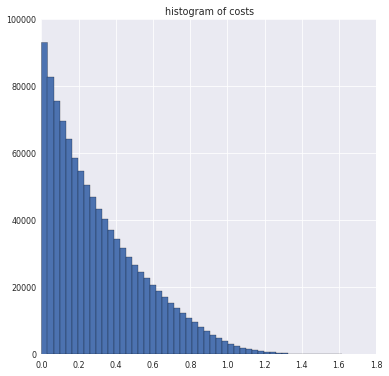

In [7]:
xmin = 0
xmax = 1

#rescale tsne'd data to xmin,xmax
X_2d2 = sklearn.preprocessing.minmax_scale(X_2d,feature_range=(xmin, xmax), axis=0)

xv, yv = np.meshgrid(np.linspace(xmin, xmax, IMAGES_PER_SIDE), np.linspace(xmin, xmax, IMAGES_PER_SIDE))
grid = np.dstack((xv, yv)).reshape(-1, 2)

cost = scipy.spatial.distance.cdist(grid, X_2d2, 'sqeuclidean')
print 'grid shape', grid.shape
print 'cost shape', cost.shape

plt.figure(figsize=(6, 6))
plt.hist(cost.flatten(), bins=50)
plt.title('histogram of costs')
plt.show()

In [8]:
#Hungarian algorithmn (gets very slow after 1k images)
%time lapcost, rowsol, colsol = lapjv.lapjv(cost)
grid_jv = grid[colsol[:NUM_IMAGES]]

CPU times: user 44.3 s, sys: 0 ns, total: 44.3 s
Wall time: 44.3 s


## Visualize

In [9]:
# convert stringios to PIL imgs
for embedding_dic in uniq_embedding_dics:
  embedding_dic['img']=Image.open(embedding_dic['stringio'])

In [10]:
def paste_at_float(big_img, small_img, ij):
  """Given a big image, a width for the small image, and an (x,y) pair in [0,1]x[0,1],
  paste the small image into the big one at (x,y)"""
  i = int(x[0]*big_image.width)
  j = int(x[1]*big_image.height)
  #img = crop_image(img, (0.50, 0.50), 0.8)
  big_image.paste(small_img, (i, j))

In [11]:
imgs = []
for embedding_dic in uniq_embedding_dics:
  img = embedding_dic['img'].resize((int(IMG_SIZE)+5, int(IMG_SIZE)+5))
  imgs.append(img)

big_image = Image.new('RGB', (int(IMG_SIZE*IMAGES_PER_SIDE), int(IMG_SIZE*IMAGES_PER_SIDE)))

for idx, x in enumerate(grid_jv):
  paste_at_float(big_image, imgs[idx], x)

/home/rycpt/virtualenv/v1/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


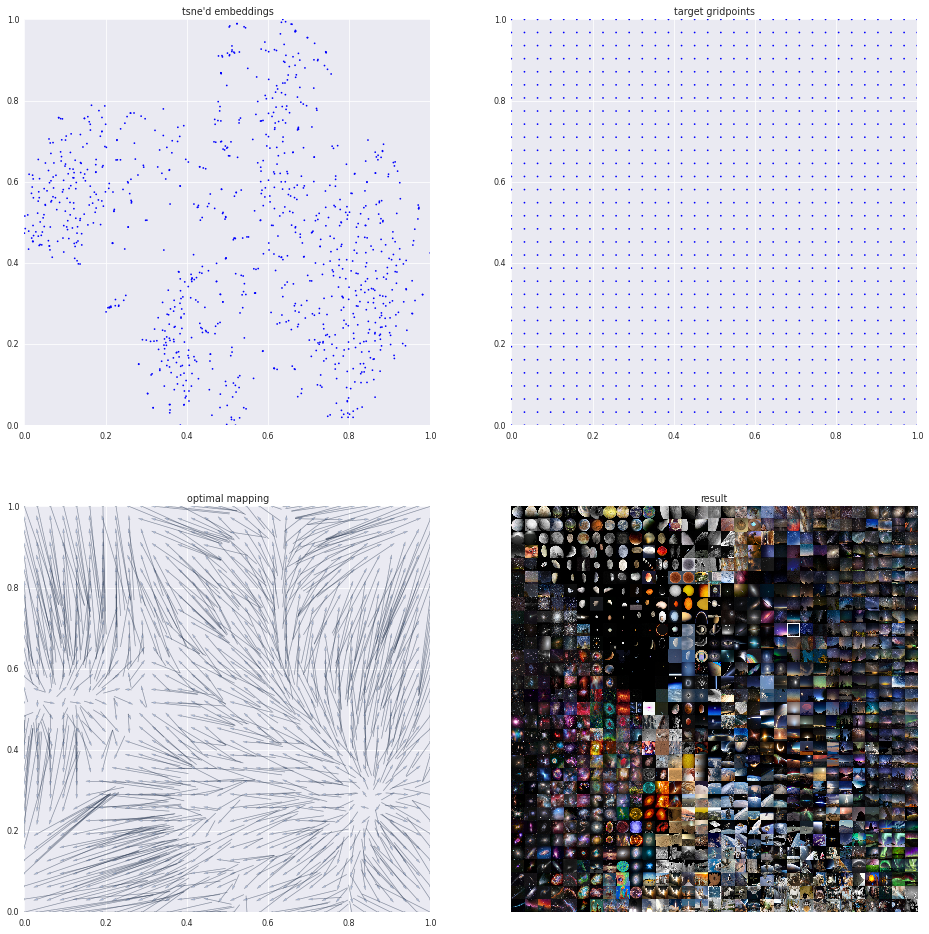

In [12]:
fig, axarr = plt.subplots(2, 2)

fig.set_figheight(16)
fig.set_figwidth(16)
axarr[0,0].scatter(X_2d2[:,0], X_2d2[:,1], s=12, marker='.', edgecolors='none')
axarr[0,0].set_title("tsne'd embeddings")
axarr[0,0].set_xlim([xmin,xmax])
axarr[0,0].set_ylim([xmin,xmax])

axarr[0,1].scatter(grid[:,0], grid[:,1], s=12, marker='.', edgecolors='none')
axarr[0,1].set_title("target gridpoints")
axarr[0,1].set_xlim([xmin,xmax])
axarr[0,1].set_ylim([xmin,xmax])

for start, end in zip(X_2d2, grid_jv):
  axarr[1,0].arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                   head_length=0.01, head_width=0.005, alpha=0.4)
axarr[1,0].set_title("optimal mapping")
axarr[1,1].imshow(big_image)
axarr[1,1].set_title("result")
axarr[1,1].axis('off')

plt.show()

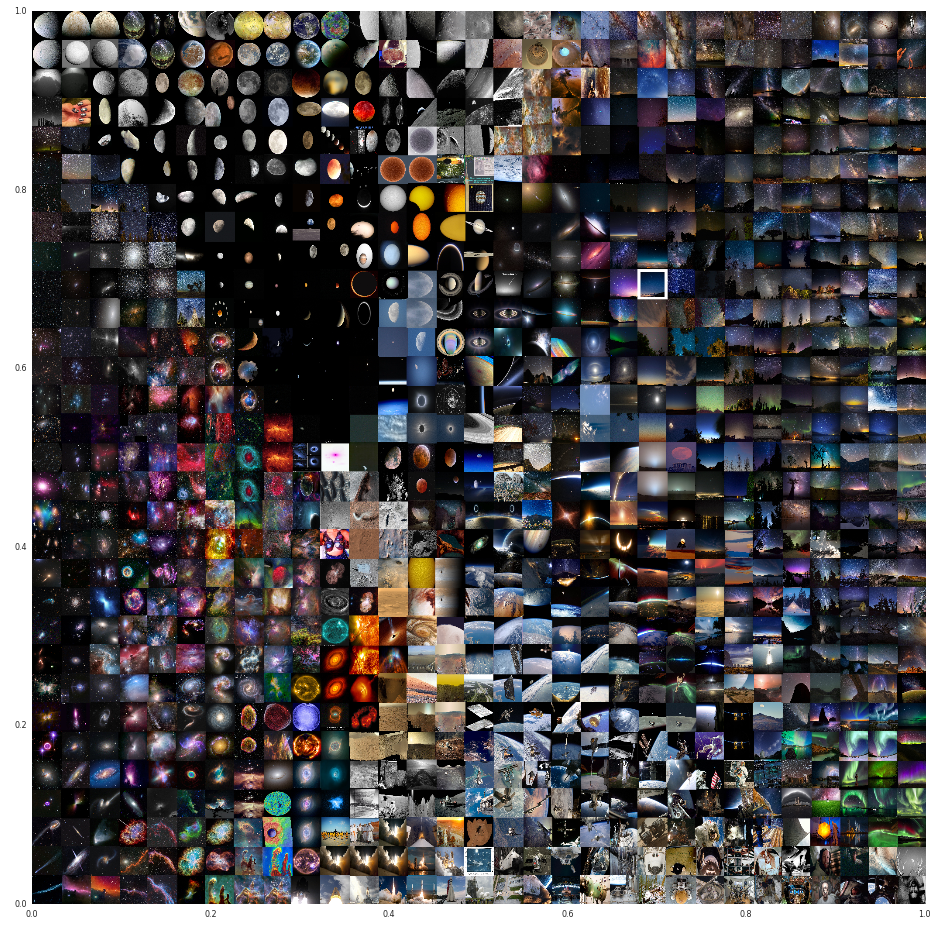

In [13]:
fig, ax = plt.subplots(figsize=(16,16))
ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(big_image)
#plt.savefig('/home/rycpt/hungarian_{}.jpg'.format(hashlib.md5(str(uniq_embedding_dics)).hexdigest()), dpi=400)